In [2]:
import xarray as xr
from utils import *
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.gaussian_process.kernels import RationalQuadratic
import importlib
import utils
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.gaussian_process.kernels import Sum, ConstantKernel, RBF, RationalQuadratic, Matern, DotProduct
import matplotlib.patches as mpatches
from itertools import combinations
import warnings
import logging
importlib.reload(utils)

<module 'utils' from '/glade/u/home/sbhattarai/GaiaFuture/Script/ML/gaussian/utils.py'>

In [3]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/sbhattarai/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:41095,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/sbhattarai/proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [4]:
#use the function read_n_wrnage, please be careful it utilizes read_all_simulation1 function
def read_n_wrangle(param, var):
    params = param_wrangling()
    filepath = os.path.join("saves", f"{var}.nc")
    global param_name, var_name
    param_name = param
    var_name = var
    var_da = read_all_simulation1(var)
    var_avg = wrangle_var_cluster(var_da)
    var_av = var_avg[var].values.flatten()
    return params, var_av, param


In [5]:
#the graphos were tested for the following variables and now no longer servers purpose
#imp_var =  ['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP']

In [6]:
#read_n_wrangle("LEAFN", "TSA")
params, var, param = read_n_wrangle("KRMAX", "GPP")

#### The follwing train_emulator function is based on permutation approach, and has the capacity to improve the model R squraed values by 2 to 3 percentage.

In [7]:
def train_emulator(params, var):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(params, var, test_size=0.2, random_state=42)

    # Define the kernels
    kernels = [
        DotProduct(sigma_0_bounds=(1e-12, 1e12)),
        RBF(length_scale_bounds=(1e-12, 1e12)),
        RationalQuadratic(length_scale_bounds=(1e-12, 1e12)),
        Matern(nu=1.5, length_scale_bounds=(1e-12, 1e12))
    ]

    # Initialize variables to keep track of the best model
    best_model = None
    best_kernel_combo = None
    best_score = float('-inf')

    # Generate all possible combinations of kernels
    kernel_combinations = []
    for r in range(1, len(kernels) + 1):
        kernel_combinations.extend(combinations(kernels, r))

    # Train a Gaussian process regressor for each kernel combination
    for kernel_combo in kernel_combinations:
        # Combine the kernels
        kernel = sum(kernel_combo)

        # Instantiate the model with the combined kernel
        gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)

        # Train the model
        gp_model.fit(X_train, y_train)

        # Evaluate the model
        score = gp_model.score(X_test, y_test)

        # Check if this model has a higher score than the best one so far
        if score > best_score:
            best_model = gp_model
            best_kernel_combo = kernel_combo
            best_score = score

    # Return the best model, its kernel combination, and other data
    return best_model, best_kernel_combo, X_train, X_test, y_train, y_test

# usage:
gp_model, best_kernel_combo, X_train, X_test, y_train, y_test = train_emulator(params, var)

/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:289: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklear

In [8]:
def process_parameter_data():
    # Function to create the parameter names dictionary
    parameter_csv_path = "/glade/u/home/djk2120/oaat_clm5_ppe/pyth/cats.csv"
    def create_parameter_names_dict():
        data = {
            key.upper(): value for key, value in {
                'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
                'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
                'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
                'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
                'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
                'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
            }.items()
        }
        return data
    #this parts gets the naming for the bar so, its required, this param df is later used in gaussian regression plot
    param_df = create_parameter_names_dict()

    # Read csv file
    full_parameter = pd.read_csv(parameter_csv_path, index_col=False)
    full_parameter = full_parameter[["param", "cat", "color"]]
    
    # Capitalize the "param" column
    full_parameter['param'] = full_parameter['param'].str.upper()
    
    # Convert parameter names dictionary to DataFrame
    paramter_dataframe = pd.DataFrame.from_dict(create_parameter_names_dict(), orient='index', columns=['Values'])
    
    # Perform inner join
    result = pd.merge(paramter_dataframe, full_parameter, left_index=True, right_on='param', how='inner')
    
    # Convert the resulting DataFrame to dictionary
    result_dict = {}
    for index, row in result.iterrows():
        param = row['Values']
        values = row.drop('Values').tolist()
        result_dict[param] = values
    
    return result_dict, param_df

# Call the function with the CSV file path
result_dict, param_df = process_parameter_data()

##### The following gaussian_regression_line has two version. the first one does not have global ylim. the following version after this one has that. 

In [9]:
#new added that has global ylim values
def gaussian_regression_line(model):
   #get the index for parameters
    index = param_df.get(param_name)
    
    # Initialize variables to store min and max y values globally
    min_y_value_global = float('inf')
    max_y_value_global = float('-inf')
    
    for param_index in range(32):
        # Generate x_values with 32 dimensions
        x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
        x_values[:, param_index] = np.linspace(0, 5, 10)  # Set the current parameter values to evenly spaced values from 0 to 1

        # Predict mean and standard deviation of the Gaussian process at each point in x_values
        y_mean, y_std = model.predict(x_values, return_std=True)
        
        # Calculate the z-score for the 99.7% confidence interval
        z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

        # Calculate y values for the 99.7% confidence interval
        y_lower = y_mean - z_score * y_std
        y_upper = y_mean + z_score * y_std
        
        # Update global min and max y values
        min_y_value_global = min(min_y_value_global, np.min(y_lower))
        max_y_value_global = max(max_y_value_global, np.max(y_upper))
        
    # Generate x_values with 32 dimensions
    x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
    x_values[:, index] = np.linspace(0, 1, 10)

    # Predict mean and standard deviation of the Gaussian process at each point in x_values
    y_mean, y_cov = model.predict(x_values, return_cov=True)

    # Plot the mean line
    plt.plot(x_values[:, index], y_mean, color='blue', linestyle='-', label='Gaussian Regression Line')

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)  # 99.7th percentile (three standard deviations)

    # Plot the shaded region for the 99.7% confidence interval with three standard deviations
    plt.fill_between(x_values[:, index], y_mean - 1.96 * np.sqrt(np.diag(y_cov)), y_mean + 1.96 *
                 np.sqrt(np.diag(y_cov)), alpha=0.2, color='k', label='95% Confidence Interval')

    plt.scatter(x_values[:, index], y_mean, c='r', label='Training Data')


    # Plot the z-score value on the plot
    plt.text(0.5, 0.5, f'99.7% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')
    plt.xlabel(f'{param_name} values between 0 and 1')
    plt.ylabel(f'{param_name} set to 1, rest all parameters to 0.5')
    plt.title('Actual Training Data vs Gaussian Regression Line with 99.7% Confidence Interval')
    plt.ylim(min_y_value_global, max_y_value_global)
    plt.legend()
    plt.show()

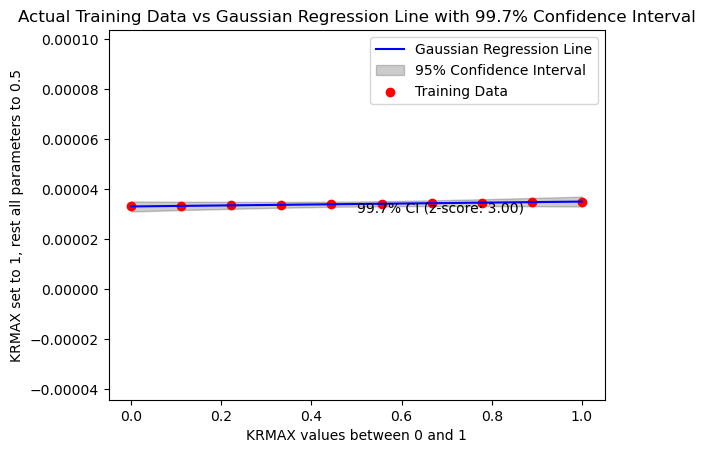

In [10]:
gaussian_regression_line(gp_model)

In [13]:
def fast_sensitivity_and_inset(model):
    # Define a custom function to generate the Gaussian regression line for each parameter
    def gaussian_regression_lines(model):
        fourier_amplitudes = []  # List to store Fourier amplitudes for each parameter
        category_colors = {}  # Dictionary to store colors for each category

        for param_index in range(32):
            # Generate x_values with 32 dimensions
            x_values = np.full((10, 32), 0.5)  # Fill array with 0.5
            x_values[:, param_index] = np.linspace(0, 1, 10)  # Set the current parameter values to evenly spaced values from 0 to 1

            # Predict mean and standard deviation of the Gaussian process at each point in x_values
            y_mean, _ = model.predict(x_values, return_std=True)

            # Compute Fourier transform of the model output
            y_fft = fft(y_mean)

            # Compute amplitude of each frequency component
            amplitude = np.abs(y_fft)

            # Store the amplitude corresponding to the first non-zero frequency (excluding DC component)
            fourier_amplitudes.append(amplitude[1])

            # Extract category and color from param_dict
            category = result_dict[param_index][1]
            color = result_dict[param_index][2]

            # If category not in category_colors, add it with its color
            if category not in category_colors:
                category_colors[category] = color

        return fourier_amplitudes, category_colors

    # Calculate Fourier amplitudes and category colors
    fourier_amplitudes, category_colors = gaussian_regression_lines(model)

    # Sort parameters based on Fourier amplitudes in descending order
    sorted_indices = np.argsort(fourier_amplitudes)
    sorted_fourier_amplitudes = np.array(fourier_amplitudes)[sorted_indices]

    # Extract parameter names corresponding to sorted indices from lookup table
    sorted_parameter_names = [result_dict[index][0] for index in sorted_indices]

    # Plot horizontal bar chart
    fig, ax = plt.subplots(figsize=(12, 14))
    bars = ax.barh(range(len(sorted_fourier_amplitudes)), sorted_fourier_amplitudes)

    # Add legend based on categories and colors
    legend_patches = []
    for category, color in category_colors.items():
        legend_patches.append(mpatches.Patch(color=color, label=category))
        fig.legend(handles=legend_patches, bbox_to_anchor=[0.5, 0.15, 0.36, 0.5], bbox_transform=fig.transFigure, fontsize='x-large')

    # Set colors of bars based on categories
    for bar, index in zip(bars, sorted_indices):
        category = result_dict[index][1]
        bar.set_color(category_colors[category])

    ax.set_ylabel('')
    ax.set_xlabel('Fourier Amplitude')
    ax.set_title(f'Fourier amplitude sensitivity test (FAST) for {var_name}')
    ax.set_yticks(range(len(sorted_fourier_amplitudes)))
    ax.set_yticklabels(sorted_parameter_names)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    #ax.set_aspect('auto', adjustable='box')

    # Define cross_val_plot function
    def cross_val_plot(model, X_train, y_train, X_test, y_test, ax=None):
        # Perform 5-fold cross-validation predictions
        y_pred_cv = cross_val_predict(model, X_train, y_train, cv=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate R-squared
        r_squared = r2_score(y_test, y_pred)

        # Calculate standard error
        std_error = np.std(y_test - y_pred)

        # Plotting
        if ax is None:
            plt.figure(figsize=(8, 8))
        else:
            ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
            ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
            ax.errorbar(y_test, y_pred, yerr=std_error, fmt='none', ecolor='black', alpha=0.5)
            if r_squared < 0.7:
                ax.annotate(f'⚠ Warning: Cross-Validation R-squared: {r_squared:.2f} < 0.7.', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=12, color='red')
            else:
                ax.annotate(f'Cross-Validation R-squared: {r_squared:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=12, color='black')

    # Call the nested cross_val_plot function
    cross_val_plot(model, X_train, y_train, X_test, y_test, ax=fig.add_axes([0.55, 0.25, 0.30, 0.25]))  # Inset plot

    # Save the plot before displaying it
    #directory_path = "~/GaiaFuture/Script/ML/gaussian/2_plots"
    #file_path = os.path.expanduser(os.path.join(directory_path, f"{var_name}_sensitivity_plot.png"))
    #plt.savefig(file_path, format='png')
    plt.show()

/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:289: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/sbhattarai/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/

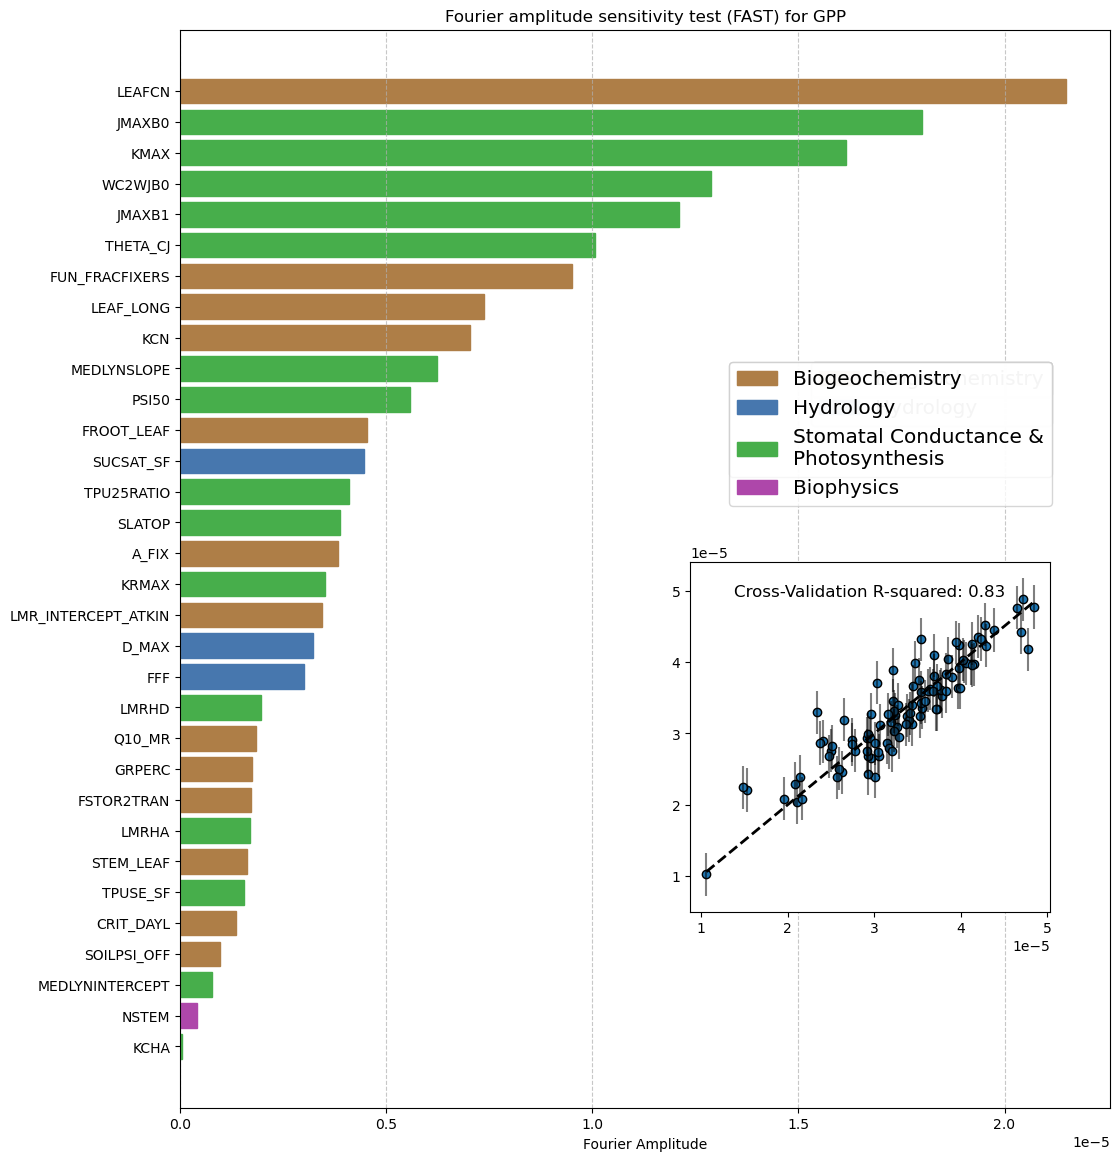

In [15]:
# model usage
fast_sensitivity_and_inset(gp_model)